In [ ]:
# Install tensorflow (if not installed)
!pip install tensorflow

In [38]:
import numpy as np 
from ml import * 
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [39]:
(y_train, labels_train), (y_test, labels_test) = mnist.load_data()

In [40]:
y_train = (y_train.reshape(y_train.shape[0], -1).astype(np.float32))
y_test = (y_test.reshape(y_test.shape[0], -1).astype(np.float32))

y_train = np.where(y_train > 0, 1, 0)
y_test = np.where(y_test > 0, 1, 0)

noise = np.random.normal(scale=0.5, size=y_test[0].shape)
X_train, X_test = y_train + noise, y_test + noise

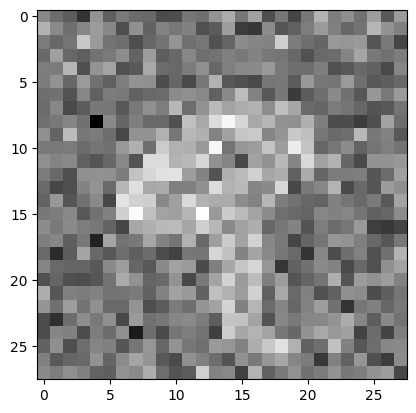

In [41]:
plt.imshow(X_train[4].reshape(28,28), cmap='gray')

In [42]:
X_train.shape

(60000, 784)

In [43]:
model = Model()
model.add(Dense(784, 32))
model.add(ReLU())
model.add(Dense(32, 8))
model.add(ReLU())
model.add(Dense(8, 8))
model.add(ReLU())
model.add(Dense(8, 32))
model.add(ReLU())
model.add(Dense(32, 784))
model.add(Sigmoid())

model.set(loss=MeanSquareError(),
          optimizer=Adam(learning_rate=0.005),
          accuracy=AccuracyRegression())

model.finalize()

In [44]:
model.summary(X_train.shape[1])

╔══════════════════════════════════════╗
║          Model Architecture          ║
╠════╬═════════╬══════════════╬════════╣
║ #  ║ Layer   ║ Output Shape ║ Params ║
╠════╬═════════╬══════════════╬════════╣
║ 1  ║ Dense   ║ (None, 32)   ║  25120 ║
║ 2  ║ ReLU    ║ (None, 32)   ║      0 ║
║ 3  ║ Dense   ║ (None, 8)    ║    264 ║
║ 4  ║ ReLU    ║ (None, 8)    ║      0 ║
║ 5  ║ Dense   ║ (None, 8)    ║     72 ║
║ 6  ║ ReLU    ║ (None, 8)    ║      0 ║
║ 7  ║ Dense   ║ (None, 32)   ║    288 ║
║ 8  ║ ReLU    ║ (None, 32)   ║      0 ║
║ 9  ║ Dense   ║ (None, 784)  ║  25872 ║
║ 10 ║ Sigmoid ║ (None, 784)  ║      0 ║
╚════╩═════════╩══════════════╩════════╝
Total trainable parameters: 51,616


In [ ]:
model.train(X_train, y_train, epochs=75, batch_size=128, print_every=100, validation_data=(X_test, y_test))

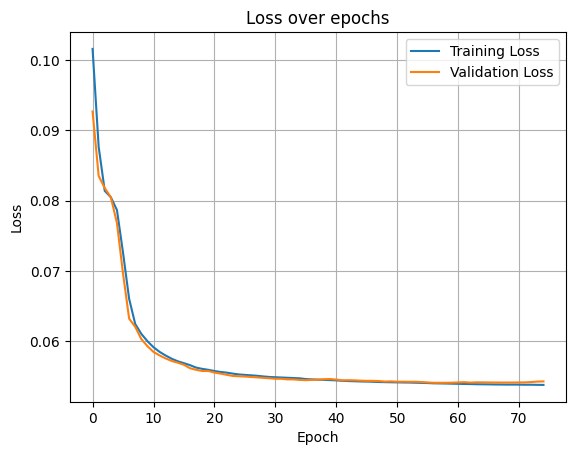

validation, acc: 724.574 loss: 0.054


In [46]:
model.plot_loss()
model.evaluate(X_test, y_test)


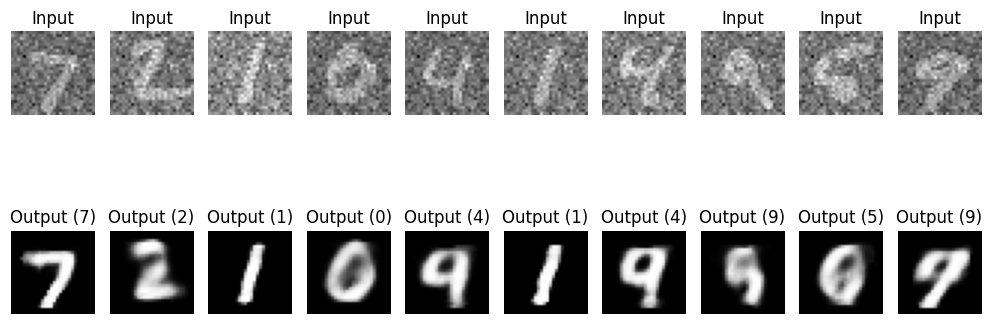

In [49]:
plt.figure(figsize=(10, 5))

for i in range(10):
    # Översta raden: input
    ax = plt.subplot(2, 10, i + 1)
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title("Input")
    ax.axis('off')

    # Undre raden: prediction
    ax = plt.subplot(2, 10, 10 + i + 1)
    ax.imshow(model.predict(X_test[i]).reshape(28, 28), cmap='gray')
    ax.set_title(f"Output ({labels_test[i]})")
    ax.axis('off')

plt.tight_layout()
plt.show()

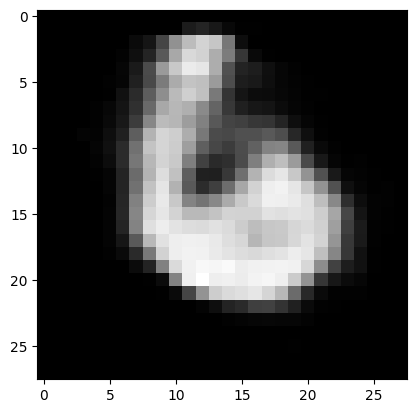

In [48]:
plt.imshow(model.predict(X_test[100]).reshape(28,28), cmap='gray')